# Cabbage or lettuce?

Let's build a classifier to distinguish:

- green cabbage
- iceberg lettuce
- romanesco cabbage

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
data_path = Path('/home/jupyter/datasets/cabbage-or-cauliflower/')

I have created 3 `.txt` files with URLs containing the 3 kinds of image

In [3]:
data_path.ls(file_exts='.txt')

(#3) [Path('/home/jupyter/datasets/cabbage-or-cauliflower/romanesco-cabbage-urls.txt'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/iceberg-lettuce-urls.txt'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage-urls.txt')]

Download files and put them into directories

In [4]:
class_names = []
for url_path in data_path.ls(file_exts='.txt'):
    file_name = url_path.name
    class_name = file_name.split('-urls.txt')[0]
    class_names.append(class_name)
    class_path = data_path/class_name
    if not class_path.exists(): class_path.mkdir()
    download_images(class_path, url_file=url_path)    

In [5]:
fns = get_image_files(data_path, folders=class_names)

In [6]:
fns

(#960) [Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000153.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000369.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000275.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000027.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000131.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000060.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000047.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000143.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000178.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000376.jpg')...]

In [7]:
failed = verify_images(fns)

In [8]:
failed

(#0) []

In [9]:
failed.map(Path.unlink);

## Create DataBlock object from data

In [10]:
get_veg_image_files = partial(get_image_files, folders=class_names)

In [11]:
veg = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # the independent and dependent variable types
    get_items=get_veg_image_files, # how to get a list of image files -- in this case from folders in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how to partition the data into training/validation sets
    get_y=parent_label, # how to get the target -- in this case from the name of the parent directory
    item_tfms=Resize(128), # transformations to apply to the data. In this case, just resize to 128x128
)

<img src="./figures/datablock.png" style="width:1000px"> 

This is the order of operations used for the DataBlock API. The Collate step loads data into mini-batches.

Dataloaders creates two loaders: one for training, one for validation.

In [12]:
dls = veg.dataloaders(data_path)

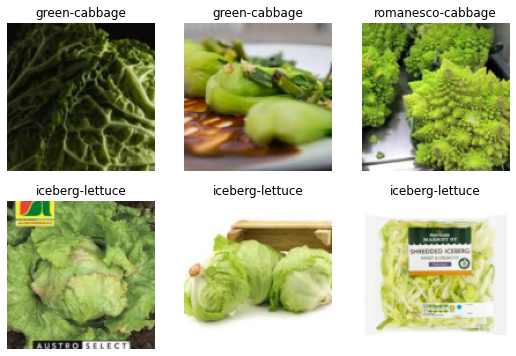

In [13]:
dls.valid.show_batch(max_n=6, nrows=2)

## Training a simple model

In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate) # just train a little resnet18
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.467651,0.885870,0.286458,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.682353,0.763186,0.255208,00:01
1,0.530810,0.814340,0.260417,00:01
2,0.422353,0.691222,0.223958,00:01
3,0.336135,0.670296,0.218750,00:01


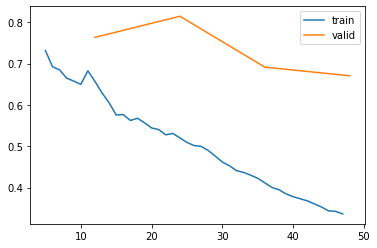

In [15]:
learn.recorder.plot_loss()

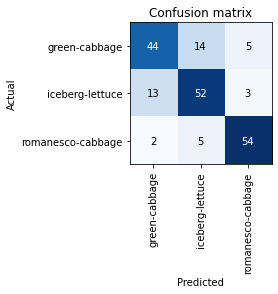

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

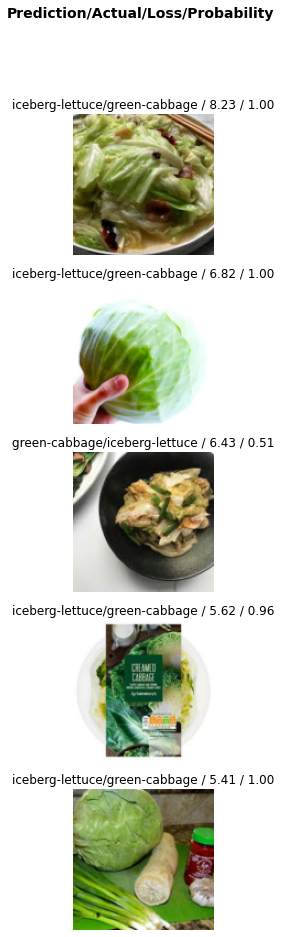

In [17]:
interp.plot_top_losses(5, nrows=5)

The images its getting wrong are either bad data or genuinely tricky cases.

## Inference time

Let's export the model, and then pretend we were using it for model inference

In [18]:
test_path = Path('./models')

In [19]:
learn.export(fname=test_path/'veg.pkl')

In [20]:
learner_inf = load_learner(test_path/'veg.pkl')

In [21]:
test_images = data_path.ls(file_exts='.jpg')

In [79]:
test_images

(#3) [Path('/home/jupyter/datasets/cabbage-or-cauliflower/romanesco.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabage.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/iceberg-lettuce.jpg')]

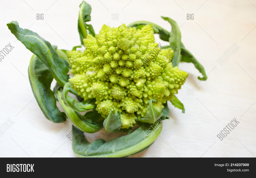

In [80]:
Image.open(data_path/'romanesco.jpg').to_thumb(256,256)

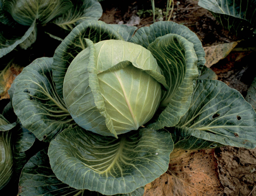

In [81]:
Image.open(data_path/'green-cabage.jpg').to_thumb(256,256)

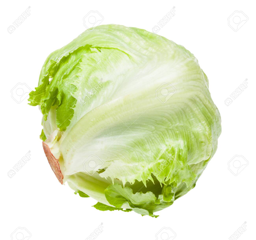

In [82]:
Image.open(data_path/'iceberg-lettuce.jpg').to_thumb(256,256)

The mapping between activations and class names is stored in the `vocab` attribute of the `DataLoaders`

In [83]:
learner_inf.dls.vocab

(#3) ['green-cabbage','iceberg-lettuce','romanesco-cabbage']

Test a Romanesco cabbage

In [27]:
learner_inf.predict(data_path/'romanesco.jpg')

('romanesco-cabbage', tensor(2), tensor([1.6718e-08, 1.6801e-06, 1.0000e+00]))

Test a green cabbage

In [28]:
learner_inf.predict(data_path/'green-cabage.jpg')

('green-cabbage', tensor(0), tensor([1.0000e+00, 3.8945e-08, 2.3596e-07]))

Test an iceberg lettuce

In [29]:
learner_inf.predict(data_path/'iceberg-lettuce.jpg')

('iceberg-lettuce', tensor(1), tensor([8.7950e-05, 9.9991e-01, 3.9247e-06]))

So the model works well, at least for clear cases.

## Resizing

The easiest way to hand images to a CNN is through square images. Our original images are all in different shapes and sizes. There are different options for how to convert a rectangular image into a square, e.g.

- Crop
- Squish
- Pad

We generate a new DataBlock from the one above, and replace `item_tfms` with a transformation which both resizes (by grabbing the centre of the image) and randomly squishes data examples.

_Default: crop the centre pixels_

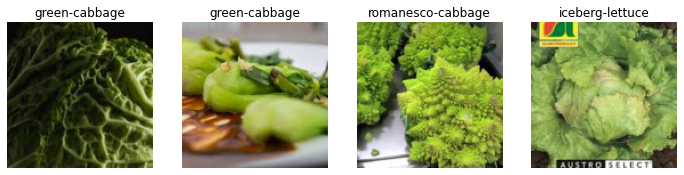

In [33]:
dls.valid.show_batch(max_n=4, nrows=1)

Pro: Doesn't alter aspect ratio. Con: loses information; assumes the object of interest is in the centre of the image.

_Squishing_

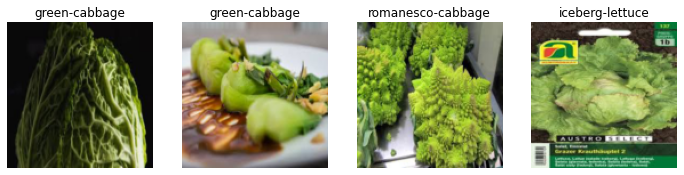

In [32]:
veg_aug = veg.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.valid.show_batch(max_n=4, nrows=1)

Pro: Efficient; no information loss. Con: Alters aspect ration meaning that i) the NN needs to learn to be invariant to squishing, ii) if the objects in question may be distinguished through aspect ratio then this transformation makes the learning task harder or perhaps impossible! Indeed, in this case, I think squishing is a bad idea.

_Padding_

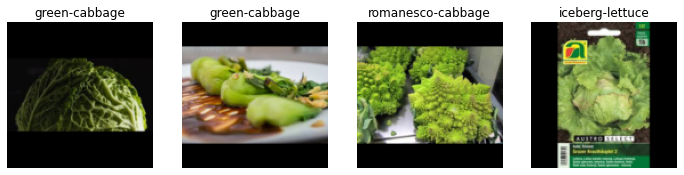

In [38]:
veg_aug = veg.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.valid.show_batch(max_n=4, nrows=1)

Pro: No information loss; retains aspect ratio. Con: inefficient: wasted computation on the padded areas.

The most common approach is to use a _random resized crop_, which grabs a different square of the image every epoch

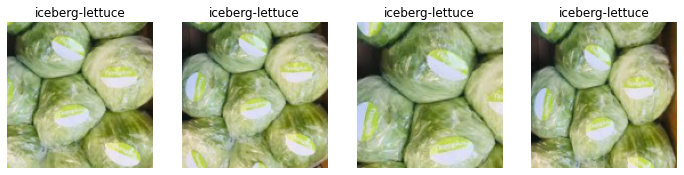

In [50]:
veg_aug = veg.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.train.show_batch(max_n=4, nrows=1, unique=True)

Pro: retains the aspect ratio; is a form of data augmentation and helps ameliorate overfitting. Con: loses information.

## Data augmentation

We can use `aug_transforms` to perform a list of augmentations simultaneously. Performs: flip, rotate, zoom, warp, lighting transforms.

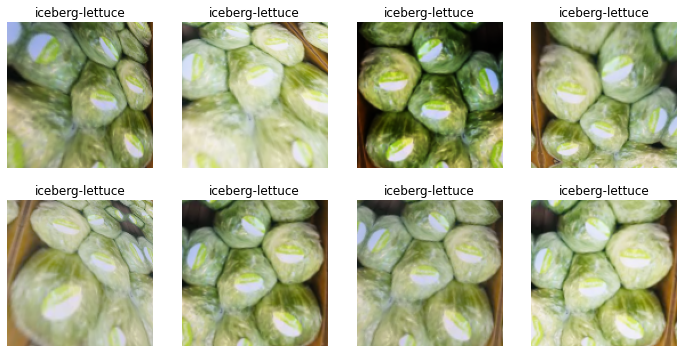

In [56]:
veg_aug = veg.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) 
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

Probably want to have `max_warp=0` in this problem setting

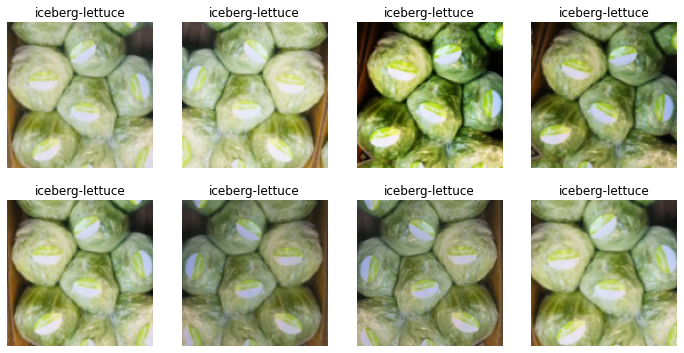

In [58]:
veg_aug = veg.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2, max_warp=0)) 
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

`batch_tfms` happen to a whole mini-batch at a time on the GPU. This allows customizable, GPU-accelerated transformations.

`fastai` will only perform these transformations on the training set, not the validation set, with the exception of `RandomResizeCrop`. For the validation set, `RandomResizeCrop` tries to get the largest centre crop it can.

## Using a model to clean data

Let's use the following data augmentation:

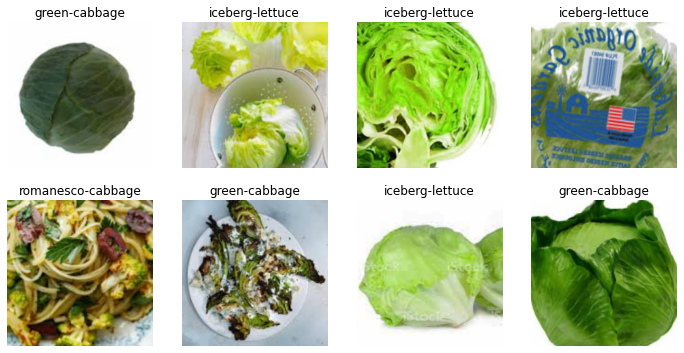

In [60]:
veg_aug = veg.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                  batch_tfms=aug_transforms(max_warp=0)) 
dls_aug = veg_aug.dataloaders(data_path)
dls_aug.train.show_batch(max_n=8, nrows=2)

Create a `Learner` and fine tune it in the usual way

In [61]:
learn = cnn_learner(dls_aug, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.255644,0.621848,0.244792,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.597054,0.631030,0.223958,00:03
1,0.476564,0.509212,0.166667,00:03
2,0.396352,0.453371,0.140625,00:03
3,0.349770,0.457551,0.151042,00:03


So already, a bit of data augmentation (along with larger images) has helped reduce the error rate.

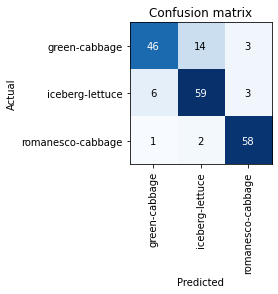

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

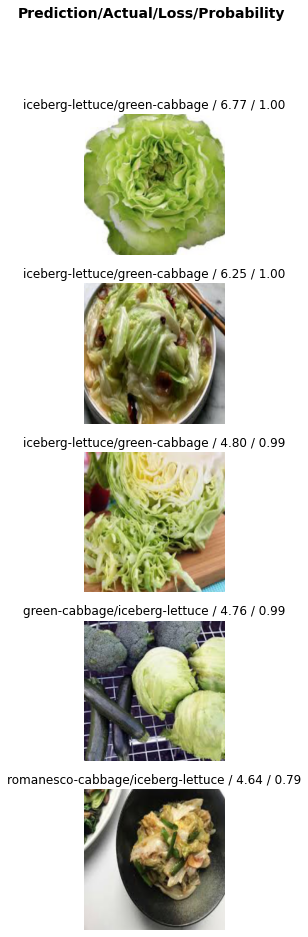

In [64]:
interp.plot_top_losses(5, nrows=5)

We didn't do any data cleaning at all before building this model. The trick here is to use a model to find the images it struggles with most, in order to weed out the bad images.

In [73]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Clean up the images from `ImageClassifierCleaner`

In [74]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() # delete bad files
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), data_path/cat) # move mislabelled files

## Reimplement the model with clean, augmented data

In [76]:
dls_aug = veg_aug.dataloaders(data_path)
learn = cnn_learner(dls_aug, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.357418,0.527437,0.186170,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.544383,0.470160,0.175532,00:03
1,0.488605,0.479687,0.154255,00:03
2,0.416555,0.420854,0.143617,00:03
3,0.351364,0.395022,0.132979,00:03


Neat! The loss is a fair bit lower than before.

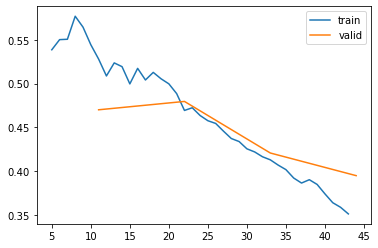

In [77]:
learn.recorder.plot_loss()

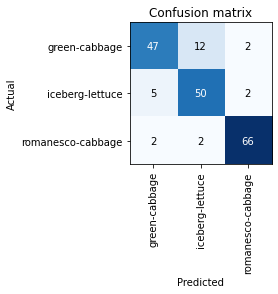

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()